In [105]:
import torch
from pathlib import Path
import sys
# import ocpmodels
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy

try:
    if not(changed):
        raise Exception()
except:
    # adds the parent directory of the current working directory to the system path.
    # This ensures that Python modules in the parent directory are accessible.
    sys.path.append(str(Path(".").absolute().parent))
    changed = True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
from ocpmodels.common.utils import (
    build_config,
    create_grid,
    save_experiment_log,
    setup_imports,
    setup_logging,
    merge_dicts,
    auto_note,
    set_min_hidden_channels
)
from ocpmodels.common import dist_utils
from ocpmodels.common.flags import flags
from ocpmodels.common.registry import registry
from ocpmodels.common.orion_utils import (
    continue_orion_exp,
    load_orion_exp,
    sample_orion_hparams,
)
import logging
from yaml import dump

In [107]:
def dict2str(d, level=0, spaces=4, margin=30):
    """
    simple recursive dict printing util
    (victor)
    """
    s = ""
    for k, v in d.items():
        s += f"{' ' *spaces * level}{k:{margin-spaces*level}}: "
        if not isinstance(v, dict):
            s += str(v)
        else:
            s += "\n" + dict2str(v, level + 1, spaces, margin)
        s += "\n"
    return s


# Config

In [108]:
sys.argv.append("--mode=train")
sys.argv.append("--config=schnet-is2re-10k")
setup_logging()

In [109]:
sys.argv.append("--mode=train")
sys.argv.append("--config=faenet-is2re_aux-all")
setup_logging()

Careful: the 100k split of the IS2RE dataset is not at "/network/scratch/s/schmidtv/ocp/datasets/ocp/is2re".

In [110]:
print("sys.argv:",sys.argv)
# enlever les arguments propres au kernel, pas dans les flags
# argument parser lit juste sys.argv
if sys.argv[1].startswith("--f"):
    sys.argv.remove(sys.argv[1])
print("sys.argv:",sys.argv)

sys.argv: ['/home/mila/b/basile.terver/ocp/ocp/venv/lib/python3.8/site-packages/ipykernel_launcher.py', '--mode=train', '--config=schnet-is2re-10k', '--mode=train', '--config=faenet-is2re_aux-all', '--mode=train', '--config=schnet-is2re-10k', '--mode=train', '--config=faenet-is2re_aux-all', '--mode=train', '--config=schnet-is2re-10k', '--mode=train', '--config=faenet-is2re_aux-all', '--mode=train', '--config=schnet-is2re-10k', '--mode=train', '--config=faenet-is2re_aux-all', '--mode=train', '--config=schnet-is2re-10k', '--mode=train', '--config=faenet-is2re_aux-all']
sys.argv: ['/home/mila/b/basile.terver/ocp/ocp/venv/lib/python3.8/site-packages/ipykernel_launcher.py', '--mode=train', '--config=schnet-is2re-10k', '--mode=train', '--config=faenet-is2re_aux-all', '--mode=train', '--config=schnet-is2re-10k', '--mode=train', '--config=faenet-is2re_aux-all', '--mode=train', '--config=schnet-is2re-10k', '--mode=train', '--config=faenet-is2re_aux-all', '--mode=train', '--config=schnet-is2re-1

In [111]:
parser = flags.get_parser()
args, override_args = parser.parse_known_args()

In [112]:
config = build_config(args, override_args)
print("Config:", "\n" + dict2str(config))

🏭 Overriding num_workers from 4 to 1 to match the machine's CPUs. Use --no_cpus_to_workers=true to disable this behavior.
Config: 
frame_averaging               : 
fa_method                     : 
model                         : 
    name                      : faenet
    act                       : swish
    hidden_channels           : 384
    num_filters               : 480
    num_interactions          : 5
    num_gaussians             : 104
    dropout_lin               : 0.0
    dropout_edge              : 0.0
    dropout_lowest_layer      : output
    first_trainable_layer     : 
    cutoff                    : 6.0
    use_pbc                   : True
    regress_forces            : 
    tag_hidden_channels       : 64
    pg_hidden_channels        : 64
    phys_embeds               : True
    phys_hidden_channels      : 0
    energy_head               : weighted-av-final-embeds
    skip_co                   : concat
    second_layer_MLP          : False
    complex_mp            

### Override config

The batch_size config in optim is the number of graphs per batch. 

To debug this notebook, I set config["optim"]["num_workers"] = 1. It seems that it's even better to set config["optim"]["num_workers"] = 0 for the prints relating to b, batch_2 and batch_3 that follow. This allows you to follow the order of the prints, whereas with num_workers >0, you have an asynchronous mix of prints. Be sure to reload the VScode window before reloading an agent.

In [113]:
config["optim"]["num_workers"] = 0
config["optim"]["batch_size"] = 3

In [114]:
config["dataset"] = dist_utils.broadcast_from_master(
config["dataset"]
)

# -- Initial setup

setup_imports()
print("\n🚩 All things imported.\n")
# -- Orion

hparams = {}

hparams = dist_utils.broadcast_from_master(hparams)
if hparams:
    print("\n💎 Received hyper-parameters from Orion:")
    print(dump(hparams), end="\n")
    trainer_config = merge_dicts(config, hparams)

# -- Setup trainer

trainer_config = continue_orion_exp(config)
trainer_config = auto_note(config)
trainer_config = set_min_hidden_channels(config)


🚩 All things imported.



In [115]:
print("Config:", "\n" + dict2str(config))

Config: 
frame_averaging               : 
fa_method                     : 
model                         : 
    name                      : faenet
    act                       : swish
    hidden_channels           : 384
    num_filters               : 480
    num_interactions          : 5
    num_gaussians             : 104
    dropout_lin               : 0.0
    dropout_edge              : 0.0
    dropout_lowest_layer      : output
    first_trainable_layer     : 
    cutoff                    : 6.0
    use_pbc                   : True
    regress_forces            : 
    tag_hidden_channels       : 64
    pg_hidden_channels        : 64
    phys_embeds               : True
    phys_hidden_channels      : 0
    energy_head               : weighted-av-final-embeds
    skip_co                   : concat
    second_layer_MLP          : False
    complex_mp                : True
    mp_type                   : base
    graph_norm                : True
    force_decoder_type        : mlp
 

In [116]:
config["logger"]="dummy"

### Make trainer and task

In [117]:
setup_imports()
# registry.get_trainer_class(config.get("trainer", "energy")) is SingleTrainer()
# all the other arguments that represent the **kwargs in the constructor of BaseTrainer()
trainer = registry.get_trainer_class(config.get("trainer", "energy"))(**config)


🧰 Trainer config:
------------------

adsorbates: all
adsorbates_ref_dir: /network/scratch/s/schmidtv/ocp/datasets/ocp/per_ads
amp: false
checkpoint_dir: /network/scratch/b/basile.terver/ocp/runs/4599478/checkpoints
cluster_name: mila
commit: 10d36598
config: faenet-is2re_aux-all
cp_data_to_tmpdir: false
cpu: false
data_split: all
dataset:
  default_val: val_id
  train:
    noisy_nodes:
      gaussian_noise_std: 0.3
      interpolate_threshold: 0.5
      min_interpolate_factor: 0.0
      type: rand
    normalize_labels: true
    split: all
    src: /network/scratch/s/schmidtv/ocp/datasets/ocp/is2re/all/train/
    target_mean: -1.525913953781128
    target_std: 2.279365062713623
  val_id:
    split: all
    src: /network/scratch/s/schmidtv/ocp/datasets/ocp/is2re/all/val_id/
  val_ood_ads:
    split: all
    src: /network/scratch/s/schmidtv/ocp/datasets/ocp/is2re/all/val_ood_ads/
  val_ood_both:
    split: all
    src: /network/scratch/s/schmidtv/ocp/datasets/ocp/is2re/all/val_ood_both/

In [118]:
task = registry.get_task_class(config["mode"])(config)
task.setup(trainer)

# Explore Trainer

In [119]:
print(trainer.__class__.__name__)

SingleTrainer


# Explore interpolate_init_relaxed_pos

In [120]:
dataset_type = type(trainer.loaders["train"].dataset).__name__
print("hex(id(trainer.loaders['train'].dataset)):",hex(id(trainer.loaders["train"].dataset)))
dataset = trainer.loaders["train"].dataset
print(dataset_type)
print("hex(id(dataset)):",hex(id(dataset)))
print("noise type:",dataset.nn_config["type"])

elt = copy.deepcopy(dataset.__getitem__(0))
print(elt.pos)
elt_2 = copy.deepcopy(dataset.__getitem__(0))
print(elt_2.pos)
elt_3 = copy.deepcopy(dataset.__getitem__(0))
print(elt_3.pos)

print("elt-elt_2=",elt.pos-elt_2.pos)
print("elt_2-elt_3=",elt_2.pos-elt_3.pos)

hex(id(trainer.loaders['train'].dataset)): 0x7fd768e89700
NoisyLmdbDataset
hex(id(dataset)): 0x7fd768e89700
noise type: rand
transforming data object of idx 0 with self.transform=Compose(
    GraphRewiring(rewiring_type=remove-tag-0)
    [inactive] FrameAveraging(fa_method=random, frame_averaging=)
)
graph.pos.device: cpu
tags: tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True])
tensor([[ 7.7468, 10.8294, 16.7841],
        [-1.1736, 14.2408, 18.6315],
        [ 0.8453,  1.5278, 17.5194],
        [ 6.7555,  1.6226, 17.1319],
        [-0.4215,  9.4315, 17.0423],
        [ 2.5988, 12.4146, 17.4669],
        [10.0244,  4.4566, 18.2900],
        [ 4.3014,  3.9519, 18.0463],
        [ 3.2467, 15.5584, 17.1093],
        [ 6.1538,  6.3792, 17.0029],
        [ 7.3462,  4.1142, 19.2291],
        [ 1.5068,  4.5369, 17.2364],
        [ 5.584

In [121]:
dataset.nn_config["type"]="constant"
print(dataset.nn_config["type"])

# const_elt = copy.deepcopy(dataset.__getitem__(0))
const_elt = dataset.__getitem__(0)
print("hex(id(const_elt)):",hex(id(const_elt)))
print(const_elt)
print(const_elt.pos)
print(hasattr(const_elt,"fixed_noise_done"))

constant
transforming data object of idx 0 with self.transform=Compose(
    GraphRewiring(rewiring_type=remove-tag-0)
    [inactive] FrameAveraging(fa_method=random, frame_averaging=)
)
constant type noise and noising the graph
graph.pos.device: cpu
tags: tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True])
hex(id(const_elt)): 0x7fb40ec624c0
Data(edge_index=[2, 498], pos=[31, 3], cell=[1, 3, 3], atomic_numbers=[31], natoms=[1], cell_offsets=[498, 3], force=[31, 3], distances=[498], fixed=[31], sid=2472718, tags=[31], y_init=6.282500615000004, y_relaxed=-0.025550085000020317, pos_relaxed=[31, 3], id='0_0', batch=[31], ptr=[2], neighbors=[1], load_time=0.0037482130000000002, transform_time=0.0014194330000000001, total_get_time=0.0051676460000000006, idx_in_dataset=0, original_pos=[31, 3], fixed_noise_done=True)
tensor([[ 6.9655, 10.

In [122]:
# const_elt_2 = copy.deepcopy(dataset.__getitem__(0))
const_elt_2 = dataset.__getitem__(0)
print("hex(id(const_elt_2)):",hex(id(const_elt_2)))
print(const_elt_2)
print(const_elt_2.pos)
print(hasattr(const_elt_2,"fixed_noise_done"))

# const_elt_3 = copy.deepcopy(dataset.__getitem__(0))
const_elt_3 = dataset.__getitem__(0)
print("hex(id(const_elt_3)):",hex(id(const_elt_3)))
print(const_elt_3)
print(const_elt_3.pos)

# const_elt_4 = copy.deepcopy(dataset.__getitem__(0))
const_elt_4 = dataset.__getitem__(0)
print("hex(id(const_elt_4)):",hex(id(const_elt_4)))
print(const_elt_4)
print(const_elt_4.pos)

print("elt-elt_2=",const_elt.pos-const_elt_2.pos)
print("elt_2-elt_3=",const_elt_2.pos-const_elt_3.pos)
print("elt_3-elt_4=",const_elt_3.pos-const_elt_4.pos)

transforming data object of idx 0 with self.transform=Compose(
    GraphRewiring(rewiring_type=remove-tag-0)
    [inactive] FrameAveraging(fa_method=random, frame_averaging=)
)
constant type noise and noising the graph
graph.pos.device: cpu
tags: tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True])
hex(id(const_elt_2)): 0x7fd76902ad90
Data(edge_index=[2, 498], pos=[31, 3], cell=[1, 3, 3], atomic_numbers=[31], natoms=[1], cell_offsets=[498, 3], force=[31, 3], distances=[498], fixed=[31], sid=2472718, tags=[31], y_init=6.282500615000004, y_relaxed=-0.025550085000020317, pos_relaxed=[31, 3], id='0_0', batch=[31], ptr=[2], neighbors=[1], load_time=0.006228764, transform_time=0.001945955, total_get_time=0.008174719, idx_in_dataset=0, original_pos=[31, 3], fixed_noise_done=True)
tensor([[ 6.9655, 10.9592, 17.1956],
        [-1.8415, 13.

## Data

In [56]:
print("trainer:",trainer)
print("trainer.loaders['train']:",trainer.loaders["train"])
print("len(trainer.loaders['train']):",len(trainer.loaders["train"]))
sampler_type = type(trainer.loaders["train"].sampler).__name__
print(f"Sampler type: {sampler_type}")
print("trainer.loaders['train'].sampler:",trainer.loaders["train"].sampler)
elt = trainer.loaders["train"].dataset.__getitem__(0)
print("elt:",elt)
elt_2 = trainer.loaders["train"].dataset.__getitem__(1)
print("elt_2:",elt_2)

trainer: <ocpmodels.trainers.single_trainer.SingleTrainer object at 0x7fd7a15f7730>
trainer.loaders['train']: <torch.utils.data.dataloader.DataLoader object at 0x7fd7a1b68910>
len(trainer.loaders['train']): 153443
Sampler type: SequentialSampler
trainer.loaders['train'].sampler: <torch.utils.data.sampler.SequentialSampler object at 0x7fd7a1b68940>
constant type noise and noising the graph
graph.pos.device: cpu
tags: tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True])
elt: Data(edge_index=[2, 498], pos=[31, 3], cell=[1, 3, 3], atomic_numbers=[31], natoms=[1], cell_offsets=[498, 3], force=[31, 3], distances=[498], fixed=[31], sid=2472718, tags=[31], y_init=6.282500615000004, y_relaxed=-0.025550085000020317, pos_relaxed=[31, 3], id='0_0', batch=[31], ptr=[2], neighbors=[1], load_time=0.003226282, transform_time=0.0013924760000000001

trainer.loaders["train"].dataset.__getitem__(0) is made of 31 atoms and trainer.loaders["train"].dataset.__getitem__(2) of 15 atoms.

When we print a dataset item, either with dataset.__getitem__() or by accessing a batch of the dataloader as we will do below, the printing only shows the shape of the attributes of the Data instance. For example, since natoms is always an integer, its shape is [1] and the printing will always yield natoms=[1]. We see the number of atoms in an item of the dataset with the shape pos=[15, 3], where here there are 15 atoms.

The length of the "all" split of the IS2RE dataset is 460328. We see it in the above print when setting batch_size to 1. When we set batch_size to k, the length of the loader is divided by k as each iteration of the loader yields k graphs, that will be subsequently collated into a batch of graphs.

In [57]:
# get 1 list of batches (depending on number of GPUs)
for batch in trainer.loaders["train"]:
    break
print("len(batch):",len(batch)) # 1?
# take the first elt of the list of batches (depending on number of GPUs)
b = batch[0]
print("b:",b)

# trainer.samplers["train"].set_epoch(0)

train_loader_iter = iter(trainer.loaders["train"])
print("train_loader_iter:",train_loader_iter)
batch_2 = next(train_loader_iter)[0] #we take [0] because a list with length the number of GPUs
print("batch_2:",batch_2)
batch_3 = next(train_loader_iter)[0]
print("batch_3:",batch_3)

constant type noise and noising the graph
graph.pos.device: cpu
tags: tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True])
constant type noise and noising the graph
graph.pos.device: cpu
tags: tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True])
constant type noise and noising the graph
graph.pos.device: cpu
tags: tensor([True, True, True, True, True, True, True, True, True, True, True, True])
len(batch): 1
b: DataBatch(edge_index=[2, 1236], pos=[64, 3], cell=[3, 3, 3], atomic_numbers=[64], natoms=[3], cell_offsets=[1236, 3], force=[64, 3], distances=[1236], fixed=[64], sid=[3], tags=[64], y_init=[3], y_relaxed=[3], pos_relaxed=[64, 3], id=[3], batch=[64], neighbors=[3], load_time=[3], transform_time=[3], total_get_time=[3], idx_in_da

b and batch\_2 are indeed the same since we build two iterators on the same dataloader. they are the same because we do not shuffle the dataset because the shuffle operation only occurs once per epoch, where an epoch is defined as one complete pass through the DataLoader.

### Batch contents

The batching is done per atoms, each element of the batch is an atom. b is a batch of atoms.

In [58]:
print("`batch` contains the graph id of each atom in the batch:")
print(b.batch.shape)
print(b.batch)

`batch` contains the graph id of each atom in the batch:
torch.Size([64])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [59]:
print("`edge_index` contains the edges of all graphs in the batch:")
print(b.edge_index.shape)
print(b.edge_index)

`edge_index` contains the edges of all graphs in the batch:
torch.Size([2, 1236])
tensor([[11, 10,  1,  ..., 55, 56, 55],
        [ 0,  0,  0,  ..., 63, 63, 63]])


In [60]:
node = 0
# Find indices where the node appears in either row of the edge_index tensor
edges_indices = (b.edge_index[0,:] == node) | (b.edge_index[1,:] == node)
print("edges_indices:",edges_indices)
# Extract the edges involving the specified node
edges_involving_node = b.edge_index[:, edges_indices]
print("edges_involving_node:",edges_involving_node)

# Print each pair
print(f"Edges involving node {node}:")
for col in range(edges_involving_node.shape[1]):
    node_pair = edges_involving_node[:, col]
    print(f"Node {node_pair[0].item()} is connected to node {node_pair[1].item()}")

edges_indices: tensor([ True,  True,  True,  ..., False, False, False])
edges_involving_node: tensor([[11, 10,  1,  5,  4,  9, 12,  6,  8,  2,  6, 13, 14, 14,  1,  2,  5,  3,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          1,  1,  2,  2,  3,  4,  5,  5,  6,  6,  8,  9, 10, 11, 12, 13, 14, 14]])
Edges involving node 0:
Node 11 is connected to node 0
Node 10 is connected to node 0
Node 1 is connected to node 0
Node 5 is connected to node 0
Node 4 is connected to node 0
Node 9 is connected to node 0
Node 12 is connected to node 0
Node 6 is connected to node 0
Node 8 is connected to node 0
Node 2 is connected to node 0
Node 6 is connected to node 0
Node 13 is connected to node 0
Node 14 is connected to node 0
Node 14 is connected to node 0
Node 1 is connected to node 0
Node 2 is connected to node 0
Node 5 is connected to node 0
Node 3 is connected to node 0
Node 0 is

In [61]:
node = 0
edges_for_node = torch.where((b.edge_index[0,:] == node) | (b.edge_index[1,:] == node))[0]
print("edges_for_node:", edges_for_node)

edges_for_node: tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  21,  32,  44,  51,  71,  77,  92, 104, 112, 115,
        148, 160, 172, 189, 215, 235, 259, 260])


In [62]:
def is_undirected(edge_index, batch, graph_id):
    # Filter edges to include only those within the specified graph_id
    nodes_in_graph = torch.where(batch == graph_id)[0]
    edges_in_graph = torch.stack([torch.isin(edge_index[0], nodes_in_graph),
                                  torch.isin(edge_index[1], nodes_in_graph)])
    edges_in_graph = torch.all(edges_in_graph, dim=0)
    edge_index_filtered = edge_index[:, edges_in_graph]
    
    # Create a set of all edges in both directions for the specified graph
    edge_set = set([(i.item(), j.item()) for i, j in zip(edge_index_filtered[0], edge_index_filtered[1])])
    
    # Check if for every edge (i, j), there exists an edge (j, i)
    for i, j in edge_set:
        if (j, i) not in edge_set:
            print("Edge without counterpart:", (i, j))
            return False  # Found an edge without its counterpart
    
    return True  # All edges have their counterparts

# Example usage
graph_id = 1
print("Is undirected within graph_id {}:".format(graph_id), is_undirected(b.edge_index, b.batch, graph_id))

Edge without counterpart: (19, 18)
Is undirected within graph_id 1: False


In [63]:
def plot_graph(edge_index, batch, graph_id):
    G = nx.Graph()
    for i in range(edge_index.shape[1]):
        source = edge_index[0, i].item()
        target = edge_index[1, i].item()
        if batch[source] == graph_id and batch[target] == graph_id:
            G.add_edge(source, target)
    
    # Adjust node labels to start from 0 for each graph
    mapping = {node: i for i, node in enumerate(sorted(G.nodes()))}
    G = nx.relabel_nodes(G, mapping)

    nx.draw(G, with_labels=True, node_color='lightblue')
    plt.show()

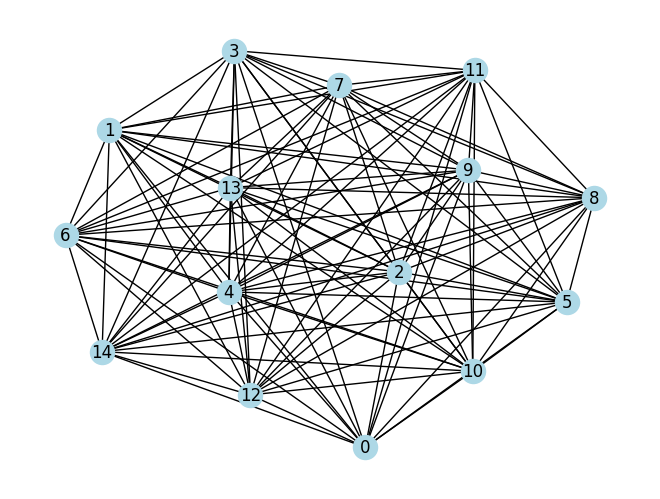

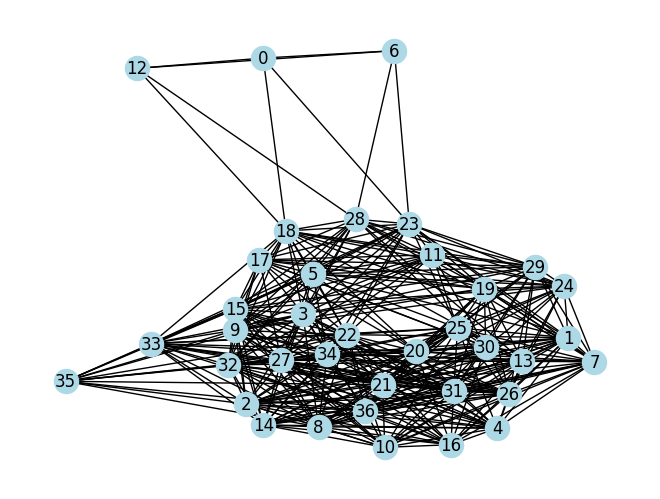

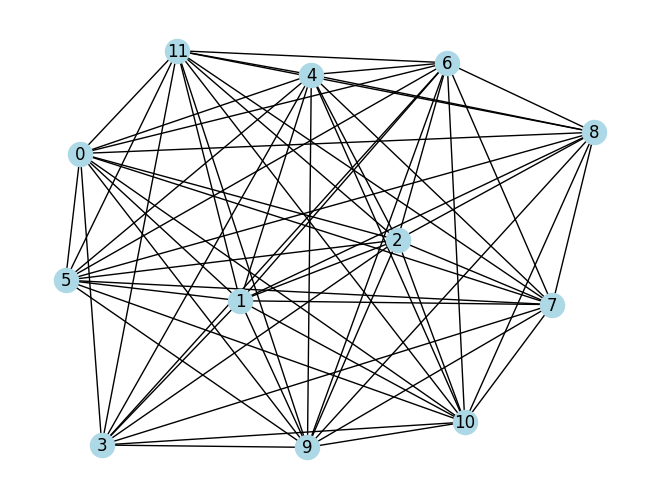

In [64]:
# Example usage for the first graph in the batch
plot_graph(b.edge_index, b.batch, graph_id=0)
plot_graph(b.edge_index, b.batch, graph_id=1)
plot_graph(b.edge_index, b.batch, graph_id=2)

In [65]:
print("`pos` and `pos_relaxed` contain the 3D position of each atom in the batch, respectively initially or in the relaxed state:")
print("b.pos.shape:",b.pos.shape)
print("b.pos_relaxed.shape:",b.pos_relaxed.shape)
print(b.pos[:3])
print(b.pos_relaxed[:3])

`pos` and `pos_relaxed` contain the 3D position of each atom in the batch, respectively initially or in the relaxed state:
b.pos.shape: torch.Size([64, 3])
b.pos_relaxed.shape: torch.Size([64, 3])
tensor([[ 7.2907,  2.6619, 23.9535],
        [ 8.7086,  1.4717, 24.3703],
        [-2.3869,  5.4056, 23.9820]])
tensor([[ 7.2410,  2.5179, 23.5834],
        [ 8.9681,  0.3747, 24.5290],
        [-2.4213,  5.5181, 23.5225]])


In [66]:
print("`cell` contains the 3D cell dimensions of each graph:")
print(b.cell.shape)
print(b.cell[:2])

`cell` contains the 3D cell dimensions of each graph:
torch.Size([3, 3, 3])
tensor([[[12.4125,  0.0000,  2.5192],
         [-5.3346,  6.9096,  1.4997],
         [ 0.0000,  0.0000, 42.7067]],

        [[ 9.7757,  0.0000,  0.0000],
         [-0.0000, 14.5422,  1.3015],
         [ 0.0000,  0.0000, 43.8010]]])


In [67]:
print("`atomic_numbers` contains the atomic number of each atom in the batch:")
print(b.atomic_numbers.shape)
print(b.atomic_numbers)

`atomic_numbers` contains the atomic number of each atom in the batch:
torch.Size([64])
tensor([30., 30., 30., 30., 50., 50.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
         1., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72.,
        72., 72., 72., 72., 72.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  1.,  8., 50., 50., 50., 50.,
         6.,  6.,  1.,  1.,  1.,  1.,  8.,  8.])


In [68]:
print("`natoms` contains the number of atoms in each graph in the batch:")
print(b.natoms.shape)
print(b.natoms)
print(b.natoms.sum())

`natoms` contains the number of atoms in each graph in the batch:
torch.Size([3])
tensor([15, 37, 12])
tensor(64)


In [69]:
print("`cell_offsets` contains the 3D 'cell offset' of each edge in the batch:\n")
print("[n_edges x 3] offset matrix where each index corresponds to the unit cell\
 offset necessary to find the corresponding neighbor in  `edge_index`. For example, \
`cell_offsets[0, :] = [0,1,0]` corresponds to `edge_index[:, 0]= [1,0]` representing \
 node 1 as node 0’s neighbor located one unit cell over in the +y direction.\n")
print(b.cell_offsets.shape)
print(b.cell_offsets)
print(torch.unique(b.cell_offsets))

print()
print()
print()

print(b.cell_offsets[38, :])
print(b.edge_index[:, 38])
print(b.cell[0])
print(b.distances[36])
print(torch.norm(b.cell[0][1]))

`cell_offsets` contains the 3D 'cell offset' of each edge in the batch:

[n_edges x 3] offset matrix where each index corresponds to the unit cell offset necessary to find the corresponding neighbor in  `edge_index`. For example, `cell_offsets[0, :] = [0,1,0]` corresponds to `edge_index[:, 0]= [1,0]` representing  node 1 as node 0’s neighbor located one unit cell over in the +y direction.

torch.Size([1236, 3])
tensor([[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0, -1,  0],
        ...,
        [-1, -1,  0],
        [ 0, -1,  0],
        [ 0, -1,  0]])
tensor([-1,  0,  1])



tensor([0, 0, 0])
tensor([12,  2])
tensor([[12.4125,  0.0000,  2.5192],
        [-5.3346,  6.9096,  1.4997],
        [ 0.0000,  0.0000, 42.7067]])
tensor(2.0883)
tensor(8.8572)


In [70]:
print("`force` contains the 3D forces 'experienced' by each atom in the batch:")
print(b.force.shape)
print(b.force)

`force` contains the 3D forces 'experienced' by each atom in the batch:
torch.Size([64, 3])
tensor([[ 2.6811e-01, -1.2547e+00, -1.0695e+00],
        [ 1.6478e-01,  1.9566e+00, -8.3042e-01],
        [ 1.0275e+00,  1.3054e+00, -2.9602e-01],
        [ 3.2476e-01, -9.5500e-01, -1.4288e+00],
        [ 1.3771e-02, -1.0215e+00,  9.0872e-01],
        [-3.2717e-01, -3.9516e-01, -6.0760e-02],
        [-2.6770e-01, -1.5730e-02, -5.1737e-02],
        [-3.1380e-01, -1.2591e-01, -1.9178e-02],
        [-1.6664e+00, -1.3184e-01, -1.1270e+00],
        [-3.5378e-01, -4.1159e-01, -5.2500e-01],
        [ 6.4905e-02, -7.5282e-02,  5.9413e-01],
        [ 4.6705e-01,  2.4380e-01,  6.6043e-01],
        [-2.8366e-01, -5.2989e-01, -2.6223e-01],
        [-1.0950e-01, -5.7161e-03,  9.1686e-01],
        [ 2.5388e+00, -5.3203e-01,  2.9424e+00],
        [ 5.8000e-07,  2.4226e-01, -4.7962e-01],
        [ 2.6514e-04, -2.8840e-01,  2.7426e+00],
        [-1.6491e+00, -2.1923e+00, -8.3113e-01],
        [-8.5865e-01,  2.8

In [71]:
print("`distances` contains the length (A?) of each edge in the batch")
print(b.distances.shape)
print(b.distances)

`distances` contains the length (A?) of each edge in the batch
torch.Size([1236])
tensor([2.0909, 2.0957, 3.4256,  ..., 5.8483, 5.8529, 5.9213])


In [72]:
print("`fixed` contains the boolean flag for each atom being fixed or not")
print(b.fixed.shape)
print(b.fixed)

`fixed` contains the boolean flag for each atom being fixed or not
torch.Size([64])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [73]:
print("`sid` contains the system id associated with each graph in the batch")
print(b.sid.shape)
print(b.sid[:5])

`sid` contains the system id associated with each graph in the batch
torch.Size([3])
tensor([2077917, 1302564, 1874170])


In [74]:
print("`tags` contains the tag of each atom: 0 - Fixed, sub-surface atoms, 1 - Free, surface atoms 2 - Free, adsorbate atoms")
print(b.tags.shape)
print(b.tags)

`tags` contains the tag of each atom: 0 - Fixed, sub-surface atoms, 1 - Free, surface atoms 2 - Free, adsorbate atoms
torch.Size([64])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2])


In [75]:
print("`y_init` and `y_relaxed` respectively contain the initial and relaxed energies of each graph:")
print(b.y_init.shape, b.y_relaxed.shape)
print(b.y_init[:5], b.y_relaxed[:5])

`y_init` and `y_relaxed` respectively contain the initial and relaxed energies of each graph:
torch.Size([3]) torch.Size([3])
tensor([ 9.2030, 21.8289,  1.5960]) tensor([ 0.8710,  0.5880, -4.9180])


In [76]:
print("`ptr` ??")
print(b.ptr.shape)
print(b.ptr)

`ptr` ??
torch.Size([4])
tensor([ 0, 15, 52, 64])


In [77]:
print("`neighbors` ??")
print(b.neighbors.shape)
print(b.neighbors)
print(b.neighbors.sum())

`neighbors` ??
torch.Size([3])
tensor([262, 788, 186])
tensor(1236)


### Find atoms in graphs

In [78]:
# select a graph you care about. graph_id is equivalent to a batch index
graph_id = 0
# find the atom indices of that graph
atoms = torch.argwhere(b.batch == graph_id).squeeze()
# the number of atoms selected above should match natoms
assert len(atoms) == b.natoms[graph_id]
print(atoms)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])


In [79]:
# find the indices of edges in that graph
# ie edges whose atoms are in the graph's atoms list
# (assumes an edge can not link 2 atoms from different graphs)
edge_indices = torch.isin(b.edge_index[0, :], atoms)
# select the actual edges from the indices
edges = b.edge_index[:, edge_indices]
print(edge_indices.shape)
print(edge_indices)
print(edges.shape)
print(edges)


torch.Size([1236])
tensor([ True,  True,  True,  ..., False, False, False])
torch.Size([2, 262])
tensor([[11, 10,  1,  5,  4,  9, 12,  6,  8,  2,  6, 13, 14, 14,  1,  2,  5,  3,
          6,  9, 11,  0,  4,  5,  3,  7, 12, 10, 13, 10,  8, 14,  0,  3,  4,  2,
          8, 13, 12, 14,  4,  3,  7,  9,  0,  7, 11, 10,  6,  5,  3,  0,  1,  7,
         13,  5,  2, 14,  8,  9, 11,  1,  6,  8, 10, 12, 12, 14,  4,  2,  1,  0,
         12,  6, 14,  2,  1,  0,  5,  9,  7, 10,  8, 13,  9, 11, 11,  3,  1,  6,
         10,  3,  0,  1,  4,  7,  8, 11, 14, 11, 12, 13,  9,  2,  0,  1,  5,  4,
         11,  9, 10, 12,  0, 14,  7,  0,  3,  2,  7, 13, 11,  8, 14,  3, 13,  9,
          8, 12,  5,  4,  2, 10,  6,  2,  1,  8,  6, 13, 11, 14,  2, 12, 13,  7,
         10, 11,  5,  3,  0,  4,  3,  1,  7,  9,  6,  1, 11,  7,  6, 13,  0,  4,
          3,  2, 14, 12, 12,  4,  5, 10,  8, 14,  0,  5, 11,  8,  6,  4, 14,  7,
         12,  3,  1,  2,  1,  9, 12, 13, 11,  0,  1,  6, 10,  9,  8,  5,  3, 13,
          5,

In [80]:
# find the forces experienced by each atom in the graph
forces = b.force[atoms]
print(forces.shape)

torch.Size([15, 3])


In [81]:
# find the length of each edge
distances = b.distances[edge_indices]
# the number of distances must match the number of edges
assert len(distances) == edges.shape[1]
print(distances.shape)

torch.Size([262])


In [82]:
# find the tag of each graph atom
tags = b.tags[atoms]
print(tags)
print(list(np.array(["fixed", "surface", "adsorbate"])[tags.cpu().numpy()]))


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2])
['surface', 'surface', 'surface', 'surface', 'surface', 'surface', 'surface', 'surface', 'surface', 'surface', 'surface', 'surface', 'surface', 'surface', 'adsorbate']


In [83]:
# find adsorbate atomic numbers
adsorbates_numbers = b.atomic_numbers[atoms][tags == 2]
print(adsorbates_numbers)

tensor([1.])


In [84]:
from ase import Atoms

x = Atoms(numbers=[int(i) for i in adsorbates_numbers])

In [85]:
symbols = []
for gid in range(len(b.sid)):
    a = torch.argwhere(b.batch == gid).squeeze()
    t  = b.tags[a]
    an = b.atomic_numbers[a][t == 2]
    symbols.append(str(Atoms(numbers=[int(i) for i in an]).symbols))

from collections import Counter

sym_counts = Counter(symbols)
print("H2O:", sym_counts.get("H2O", 0))
print("H2:", sym_counts.get("H2", 0))
print()
print(dict2str(sym_counts, margin=10))

H2O: 0
H2: 0

H         : 1
N2HO      : 1
C2H4O2    : 1



In [86]:
# forward the batch, compute loss and metrics

out = trainer._forward(batch)
loss = trainer._compute_loss(out, batch)
metrics = trainer.compute_metrics(
    out,
    batch,
    trainer.evaluator,
    metrics={},
)


AttributeError: 'SingleTrainer' object has no attribute '_forward'

In [ ]:
# explore contents of predictions, loss, metrics

print(out.keys())
print(out["energy"].shape, out["energy"].dtype)
print(loss)
print(dict2str(metrics))

NameError: name 'out' is not defined

## LMDBs

In [ ]:
def ls(p):

    assert Path(p).is_dir()
    return list(Path(p).iterdir())

In [ ]:
d = trainer.train_loader.dataset

AttributeError: 'SingleTrainer' object has no attribute 'train_loader'

In [ ]:
d.path

PosixPath('/network/projects/_groups/ocp/oc20/is2re/10k/train/data.lmdb')

In [ ]:
ls(d.path.parent)

[PosixPath('/network/projects/_groups/ocp/oc20/is2re/10k/train/data.lmdb-lock'),
 PosixPath('/network/projects/_groups/ocp/oc20/is2re/10k/train/data.lmdb')]

In [ ]:
d.env

In [ ]:
import lmdb



In [ ]:
d.env.stat()["entries"]

10000

In [ ]:
f"{0}".encode("ascii")

b'0'

In [ ]:
import pickle

sample = pickle.loads(d.env.begin().get(f"{0}".encode("ascii")))

In [ ]:
from torch_geometric.data import Data

sample = Data(**{k: v for k, v in sample.__dict__.items() if v is not None})

In [ ]:
sample

Data(edge_index=[2, 2964], pos=[86, 3], cell=[1, 3, 3], atomic_numbers=[86], natoms=86, cell_offsets=[2964, 3], force=[86, 3], distances=[2964], fixed=[86], sid=2472718, tags=[86], y_init=6.282500615000004, y_relaxed=-0.025550085000020317, pos_relaxed=[86, 3])